<a href="https://colab.research.google.com/github/lucas-prado/data_science_portfolio/blob/main/%5BPROJETO%5D_Churn_Prediction_para_uma_empresa_de_Telecomunica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [ ]:
# importar os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer, confusion_matrix, plot_confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler

import xgboost as xgb

# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## **ENTENDENDO O PROBLEMA - TRATAMENTO E ANÁLISE EXPLORATÓRIA DOS DADOS**





### **Variável Target (Churn):**

  *   Churn = Yes -> evasão do cliente
  *   Churn = No -> não evasão do cliente


In [ ]:
#Dimensões do dataframe

print(f"número de linhas: {df.shape[0]}")
print(f"número de colunas: {df.shape[1]}")

número de linhas: 7043
número de colunas: 21


### **Inferências sobre a tipagem das colunas:**

* CustomerID será eliminada por não representar empiricamente relação nenhuma com Churn.

* Possuímos ao total:

  *   3 variáveis numéricas
  *   17 variáveis categóricas -> importante para aplicação de técnicas de classificação (one-hot encoding)

* Ponto de atenção para a variável **Total Charges** que apresenta variáveis numéricas, mas está sendo classificada com *object*.

In [ ]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [ ]:
df.drop(["customerID"], axis=1, inplace=True)

### **Missing Values**

* A princípio, não existem **Missing Values** nas colunas. Porém, foi necessário verificar o porquê de a variável **TotalCharges** não se enquadrar como uma variável do tipo **numérica.**

* Foi descoberto que existiam valores vazios que não se configuravam como *np.nan* na coluna **TotalCharges.** Foi feito o tratamento de substituição e, após refeito o cálculo, dada a baixa porcentagem, foi escolhido **eliminar as linhas com missing values**.

* A mesma análise foi feita para as demais colunas **object** para verificar a existência de valores não condizentes com o esperado das variáveis. Confirmou-se a não existência e a análise pode ser prosseguida.




In [ ]:
df.isnull().sum()/df.shape[0]

gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [ ]:
#Não foi possível averiguar a existência de variáveis estranhas pela função unique.

df["TotalCharges"].unique()

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [ ]:
#Ordenamos pela variável em análise para encontrar quais observações transformar a coluna em "object"

df.sort_values(by="TotalCharges").head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No


In [ ]:
#Substituindo valores vazio em string por np.nan

df["TotalCharges"].replace(" ", np.nan, inplace=True)

In [ ]:
#Revendo os missing values, após o tratamento.

df.isnull().sum()/df.shape[0]

gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
tenure              0.000000
PhoneService        0.000000
MultipleLines       0.000000
InternetService     0.000000
OnlineSecurity      0.000000
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
StreamingMovies     0.000000
Contract            0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.001562
Churn               0.000000
dtype: float64

In [ ]:
#Eliminando os valores nulos.

df.dropna(subset=["TotalCharges"], inplace=True)

In [ ]:
#Transformando a coluna TotalCharges em numérica.

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], downcast="float")

In [ ]:
#Analisando as colunas object para verificar a existência

for c, l in enumerate(df.dtypes):
  if l=="object":
    print(f"columns: {df.dtypes.index[c]}")
    print(df[df.dtypes.index[c]].unique())

columns: gender
['Female' 'Male']
columns: Partner
['Yes' 'No']
columns: Dependents
['No' 'Yes']
columns: PhoneService
['No' 'Yes']
columns: MultipleLines
['No phone service' 'No' 'Yes']
columns: InternetService
['DSL' 'Fiber optic' 'No']
columns: OnlineSecurity
['No' 'Yes' 'No internet service']
columns: OnlineBackup
['Yes' 'No' 'No internet service']
columns: DeviceProtection
['No' 'Yes' 'No internet service']
columns: TechSupport
['No' 'Yes' 'No internet service']
columns: StreamingTV
['No' 'Yes' 'No internet service']
columns: StreamingMovies
['No' 'Yes' 'No internet service']
columns: Contract
['Month-to-month' 'One year' 'Two year']
columns: PaperlessBilling
['Yes' 'No']
columns: PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
columns: Churn
['No' 'Yes']


### **Estatística descritiva e demais análises de comportamento das variáveis**

* A análise da estatística descritiva permite inferir, desconsiderando a variável **SeniorCitizen** por ser binária, que:

  1.   Todas as variáveis, a princípio, não parecem possuir uma alta incidência de **outliers**, visto que a média e a mediana possuem valores bastante próximos. Salvo a coluna **TotalCharges** que deverá ser analisada com mais cuidado.

  2.   A variável **TotalCharges** possui uma dimensionalidade diferente das demais. Em caso de uso de um modelo linear generalizado de classificação, como a Regressão Logística, será necessário padronizar as variáveis.

* Ao avaliarmos o boxplot das variáveis, obtemos a confirmação da não existência de outliers, inferida anteriormente.

### **Balanceamento dos dados**

* A princípio, temos uma proporção desbalanceada entre as classificações **"Yes"** e **"No"**. Optaremos por desenvolver o modelo sem o tratamento via técnica **undersampling** ou **oversampling**. Caso os resultados não sejam promissores para o acerto da classificação mais sensível **"Yes"**, optaremos por readequar o balanceamento para melhores resultados.

In [ ]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.298340
std,0.368844,24.545260,30.085974,2266.770508
min,0.000000,1.000000,18.250000,18.799999
25%,0.000000,9.000000,35.587500,401.449997
50%,0.000000,29.000000,70.350000,1397.475037
75%,0.000000,55.000000,89.862500,3794.737488
max,1.000000,72.000000,118.750000,8684.799805


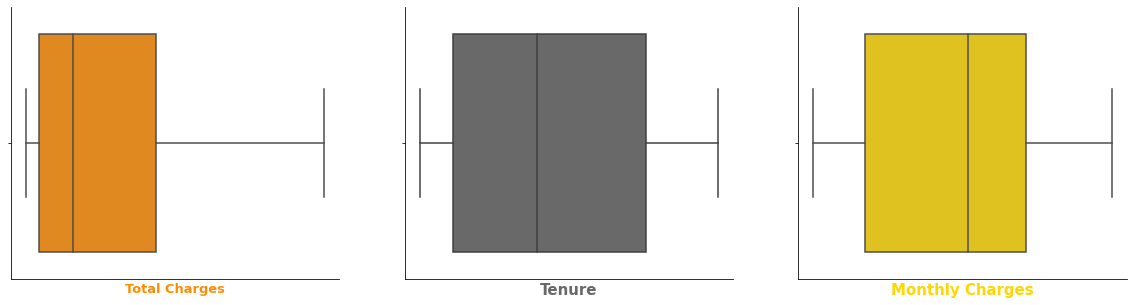

In [ ]:
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, figsize=(20, 5))

sns.boxplot(x="TotalCharges", data=df, ax=ax1, color="darkorange")
ax1.set_xlabel("Total Charges", size=13, weight="bold", color="darkorange")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_xticklabels(labels=[], visible=False)
ax1.set_xticks(ticks=[])

sns.boxplot(x="tenure", data=df, ax=ax2, color="dimgrey")
ax2.set_xlabel("Tenure", size=15, weight="bold", color="dimgrey")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.set_xticklabels(labels=[], visible=False)
ax2.set_xticks(ticks=[])

sns.boxplot(x="MonthlyCharges", data=df, ax=ax3, color="gold")
ax3.set_xlabel("Monthly Charges", size=15, weight="bold", color="gold")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.set_xticklabels(labels=[], visible=False)
ax3.set_xticks(ticks=[])

plt.show()

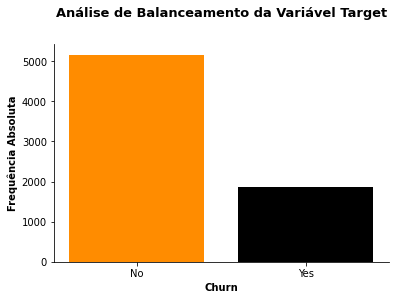

Proporção - Classificação 'No': 5163.00
Proporção - Classificação 'Yes': 1869.00


In [ ]:
fig, ax = plt.subplots()

ax.set_title("Análise de Balanceamento da Variável Target", size=13, weight="bold", y=1.1)

ax.bar(df["Churn"].value_counts().index, df["Churn"].value_counts().values, color=["darkorange", "black"])
ax.set_xlabel("Churn", size=10, weight="bold")
ax.set_ylabel("Frequência Absoluta", size=10, weight="bold")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show();

no = df["Churn"].value_counts().values[0]
yes = df["Churn"].value_counts().values[1]

print("Proporção - Classificação 'No': {:.2f}".format(no))
print("Proporção - Classificação 'Yes': {:.2f}".format(yes))

## **FORMATANDO OS DADOS PARA O MODELO**

Como utilizaremos um modelo **XGBoost**, um modelo derivado de **decision trees**, não será necessário padronizar as variáveis. 

  **1.** Separação entre as variáveis explicativas e a variável target.

  **2.** Aplicação do ONE-HOT ENCODING.

  * Dessa maneira, nós garantimos que o modelo trate variáveis categóricas em categorias separadas, não possuindo uma relação direta entre elas que pode vir a enviesar o modelo.

**3.** Separação dos datasets entre treino e teste.

In [ ]:
#Separação das variáveis.

X = df.drop("Churn", axis=1).copy()
y = df["Churn"].copy()

In [ ]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.850000
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.500000
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.150002
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.750000
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.649994


In [ ]:
y.head()

0     No
1     No
2    Yes
3     No
4    Yes
Name: Churn, dtype: object

In [ ]:
#One-Hot Encoding

columns_objects = list()

for c, l in enumerate(X.dtypes):
  if l=="object":
    columns_objects.append(X.dtypes.index[c])

X_encoded = pd.get_dummies(X, columns=columns_objects)

In [ ]:
X_encoded.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.850000,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.500000,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.150002,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.750000,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.649994,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


In [ ]:
y_encoded = pd.Series(np.where(y.values == 'Yes', 1, 0))

In [ ]:
y_encoded.unique()

array([0, 1])

In [ ]:
print(y.value_counts().values[0])
print(y.value_counts().values[1])

5163
1869


In [ ]:
#Separando os datasets entre treino e teste.

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.30, stratify=y, random_state=42)

In [ ]:
X_train.shape

(4922, 45)

In [ ]:
X_train.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
4499,0,12,78.30,909.250000,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1933,0,20,19.70,415.899994,0,1,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1
4668,0,2,61.20,125.949997,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0
5681,1,34,64.20,2106.300049,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0
3610,0,12,100.15,1164.300049,1,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0


In [ ]:
X_test.shape

(2110, 45)

In [ ]:
X_train.shape

(4922, 45)

In [ ]:
y_train.shape

(4922,)

## **MODELO 1 -  XGBOOST**

* Dado que uma saída de clientes, ou seja, a ocorrência da variável Churn, seria o evento mais sensível e custoso à companhia, é necessário que a nossa previsão esteja consideravelmente calibrada para que esse evento possa ser antecipado. 

* Portanto, o foco de avaliação do modelo está nas métricas de Recall, visto que ela avalia diretamente a quantidade prevista em relação à quantidade verdade de classificações 1 e 0.

* Em termos de comparação de modelos, nos pautaremos na métrica de AUC, analisando a relação entre a True Positive Rate X False Positive Rate, visto que o foco do modelo é performar bem nas previsões de classificação 1.

In [ ]:
clf_xgb = xgb.XGBClassifier(objective="binary:logistic", seed=42, missing=None)
clf_xgb.fit(X_train, 
            y_train,
            eval_metric = "auc",
            verbose = True,
            early_stopping_rounds = 10,
            eval_set=[(X_test, y_test)]
            )

In [ ]:
 y_pred = clf_xgb.predict(X_test)

#### **Análise dos resultados - Modelo 1**

* Percebe-se uma boa performance do modelo, sem a otimização dos hiperparâmetros, para as classificações 0. Porém, o modelo não performou bem para as classificações 1, que são as previsões mais sensíveis de acerto para a empresa. 

* Provavelmente, os resultados não foram favoráveis devido ao desbalanceamento entre classificações 0s e 1s apresentadas no dataset. 

* Para calibrar as previsões, otimizaremos os hiperparâmetros nos próximos modelos juntamente com o tratamento do balanceamento dos dados de classificação.

**Classificações - 0/No:**

* **Precision:** 83,21%
* **Recall:** 90,57%

**Classificações - 1/Yes:**

* **Precision:** 65,57%
* **Recall:** 49,55%

**Avaliações gerais do modelo:**

* **AUC:** 70,06%
* **Accuracy:** 79,67% 



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0     0.8321    0.9057    0.8674      1549
           1     0.6557    0.4955    0.5645       561

    accuracy                         0.7967      2110
   macro avg     0.7439    0.7006    0.7159      2110
weighted avg     0.7852    0.7967    0.7868      2110

AUC: 0.7006
Accuracy:0.7967


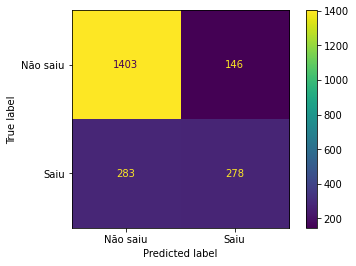

In [ ]:
plot_confusion_matrix(
    clf_xgb,
    X_test,
    y_test,
    display_labels=["Não saiu", "Saiu"]
)

print(classification_report(y_test, y_pred, digits=4))
print("AUC: {:.4f}".format(roc_auc_score(y_test, y_pred)))
print("Accuracy:{:.4f}".format(accuracy_score(y_test, y_pred)))

## **MODELO 2 - XGBOOST COM OTIMIZAÇÃO DE HIPERPARÂMETROS E BALANCEAMENTO DE DADOS** 

**Principais hiperparâmetros:**

* **Scale_Pos_Weight:** adiciona uma penalidade para classificações incorretas na classe minoritária. No caso, essa classe minoritária são as classificações **Yes**. Aumentando essa penalidade, as árvores tentarão de maneira mais eficiente classificar essa classe corretamente.

* **Subsample e Colsample_bytree:** utilizaremos uma porcentagem da amostra e das variáveis que serão escolhidas aleatoriamente a cada criação das árvores XGBoost para evitar overfitting.

* **Learning_rate/Eta:** taxa de aprendizado/incremento dos output values de cada weak learner na previsão inicial.

* **Gamma:** parâmetro de pruning para evitar overfitting.

* **Reg_Lambda:** parâmetro de regularização para evitar overfitting.

* **cv:** parâmetro de validação cruzada.

In [ ]:
param_grid_1 = {
    'learning_rate': [0.3, 0.1, 0.01],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda':[0, 1.0, 10.0],
}

In [ ]:
optimal_params_1 = GridSearchCV(
    estimator=xgb.XGBClassifier(
                  objective="binary:logistic",
                  seed=42,
                  subsample=0.9,
                  scale_pos_weight=2.76,
                  colsample_bytree=0.5),
        param_grid = param_grid_1,
        scoring='roc_auc',
        verbose=2,
        n_jobs=10,
        cv=3
    )

In [ ]:
optimal_params_1.fit(
    X_train,
    y_train,
    early_stopping_rounds=10,
    eval_set =[(X_test, y_test)],
    eval_metric="auc",
    verbose=False
)

print("Melhor Score: {:.4f}".format(optimal_params_1.best_score_))
print("Melhores Parâmetros: {}".format(optimal_params_1.best_params_))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Melhor Score: 0.8499
Melhores Parâmetros: {'gamma': 0.25, 'learning_rate': 0.1, 'reg_lambda': 10.0}


In [ ]:
clf_xgb = xgb.XGBClassifier(seed=42,
                            objective='binary:logistic',
                            gamma=0.25,
                            learn_rate=0.1,
                            reg_lambda=10,
                            scale_pos_weight=2.76,
                            subsample=0.9,
                            colsample_bytree=0.5)

clf_xgb.fit(X_train,
            y_train,
            early_stopping_rounds=10,
            eval_metric='auc',
            eval_set=[(X_test, y_test)])

In [ ]:
 y_pred = clf_xgb.predict(X_test)

#### **Análise dos resultados - Modelo 2.1**

* A primeira tentativa de otimização de hiperparâmetros nos trouxeram os seguintes valores:

  * gamma: 0.25, learning_rate: 0.1, reg_lambda: 10.0

* Iremos testar novamente parâmetros para **reg_lambda**, visto que, como a escolha do melhor hiperparâmetro foi o último número do intervalo (10.0), pode ser que números maiores a esse gerem resultados melhores.

**Classificações - 0/No:**

* **Precision:** 91,32%
* **Recall:** 71,34%

**Classificações - 1/Yes:**

* **Precision:** 50,67%
* **Recall:** 81,28%

**Avaliações gerais do modelo:**

* **AUC:** 76,31%
* **Accuracy:** 73,98% 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0     0.9132    0.7134    0.8010      1549
           1     0.5067    0.8128    0.6242       561

    accuracy                         0.7398      2110
   macro avg     0.7099    0.7631    0.7126      2110
weighted avg     0.8051    0.7398    0.7540      2110

AUC: 0.7631
Accuracy:0.7398


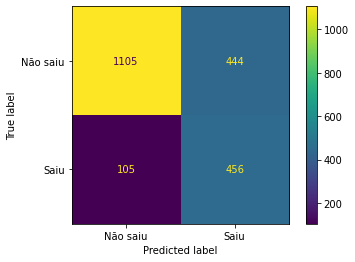

In [ ]:
plot_confusion_matrix(
    clf_xgb,
    X_test,
    y_test,
    display_labels=["Não saiu", "Saiu"]
)

print(classification_report(y_test, y_pred, digits=4))
print("AUC: {:.4f}".format(roc_auc_score(y_test, y_pred)))
print("Accuracy:{:.4f}".format(accuracy_score(y_test, y_pred)))

In [ ]:
param_grid_2 = {
    'learning_rate': [0.1],
    'gamma': [0.25],
    'reg_lambda':[10.0, 15.0,20.0],
}

In [ ]:
optimal_params_2 = GridSearchCV(
    estimator=xgb.XGBClassifier(
                  objective="binary:logistic",
                  seed=42,
                  subsample=0.9,
                  scale_pos_weight=2.76,
                  colsample_bytree=0.5),
        param_grid = param_grid_2,
        scoring='roc_auc',
        verbose=2,
        n_jobs=10,
        cv=3
    )

In [ ]:
optimal_params_2.fit(
    X_train,
    y_train,
    early_stopping_rounds=10,
    eval_set =[(X_test, y_test)],
    eval_metric="auc",
    verbose=False
)

print("Melhor Score: {:.4f}".format(optimal_params_2.best_score_))
print("Melhores Parâmetros: {}".format(optimal_params_2.best_params_))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Melhor Score: 0.8501
Melhores Parâmetros: {'gamma': 0.25, 'learning_rate': 0.1, 'reg_lambda': 15.0}


In [ ]:
clf_xgb = xgb.XGBClassifier(seed=42,
                            objective='binary:logistic',
                            gamma=0.25,
                            learn_rate=0.1,
                            reg_lambda=15,
                            scale_pos_weight=2.76,
                            subsample=0.9,
                            colsample_bytree=0.5)

clf_xgb.fit(X_train,
            y_train,
            early_stopping_rounds=10,
            eval_metric='auc',
            eval_set=[(X_test, y_test)])

In [ ]:
y_pred = clf_xgb.predict(X_test)

#### **Análise dos resultados - Modelo 2.2**

* A segunda tentativa de otimização de hiperparâmetros nos trouxeram os seguintes valores:

  * gamma: 0.25, learning_rate: 0.1, reg_lambda: 15.0

* Não ocorreu uma melhora substancial do modelo 2.2 em relação ao 2.1, mas os parâmetros serão mantidos dessa maneira.

**Classificações - 0/No:**

* **Precision:** 91,55%
* **Recall:** 71,34%

**Classificações - 1/Yes:**

* **Precision:** 50,83%
* **Recall:** 81,82%

**Avaliações gerais do modelo:**

* **AUC:** 76,58%
* **Accuracy:** 74,12% 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0     0.9155    0.7134    0.8019      1549
           1     0.5083    0.8182    0.6270       561

    accuracy                         0.7412      2110
   macro avg     0.7119    0.7658    0.7145      2110
weighted avg     0.8072    0.7412    0.7554      2110

AUC: 0.7658
Accuracy:0.7412


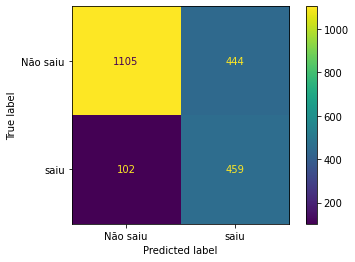

In [ ]:
plot_confusion_matrix(
    clf_xgb,
    X_test,
    y_test,
    display_labels=["Não saiu", "saiu"]
)

print(classification_report(y_test, y_pred, digits=4))
print("AUC: {:.4f}".format(roc_auc_score(y_test, y_pred)))
print("Accuracy:{:.4f}".format(accuracy_score(y_test, y_pred)))

## **CONCLUSÃO**

* Após tratamento dos hiperparâmetros, obtivemos uma melhora substancial das previsões de classificações **Yes** em detrimento das previsões de classificações **No**.

* Entende-se a necessidade de comparar o resultado com outros modelos de classificação ou com outras técnicas de balanceamento de dados. No entanto, a opção pelo XGBoost foi especificamente pelo estudo da aplicação deste algoritmo e seus parâmetros em específico.